In [292]:
import pandas as pd
import numpy as np
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [293]:
import warnings
warnings.filterwarnings('ignore')

## Data

In [357]:
flu_df = pd.read_csv('data/flu_data.csv')
flu_df = flu_df.rename(columns = {'Unnamed: 0': 'date'})
flu_df.head()

,date,date,Texas,Louisiana,Washington,New Jersey,Arkansas,Montana,North Dakota,Virgin Islands,...,Nevada,Idaho,Utah,Virginia,New York,District of Columbia,Oklahoma,South Dakota,New York City,Colorado
0,0,2010-40,2.06514,2.28108,0.510041,2.31534,0.696056,0.037119,0.671355,NaN,...,1.66683,0.414938,0.747696,1.14343,0.262990,2.80877,0.624179,1.102750,1.18222,0.660684
1,1,2010-41,2.09394,2.04776,1.040070,2.47836,0.674157,0.180963,0.721961,NaN,...,1.63633,1.457980,0.410939,1.23653,0.369729,2.89079,0.958678,0.793794,1.40230,0.628621
2,2,2010-42,2.10072,2.42974,0.904393,2.24812,0.514217,0.185874,0.567477,NaN,...,1.50860,1.408140,0.440583,1.22545,0.362121,2.41042,2.070390,0.791023,1.29124,0.804020
3,3,2010-43,2.20655,1.92854,0.955110,2.79286,0.413650,0.036390,0.339239,NaN,...,2.14451,1.280070,0.755957,1.26902,0.358981,3.11632,1.670730,0.801311,1.30236,0.909658
4,4,2010-44,2.36381,2.80934,0.786370,1.82877,1.090280,0.040519,0.713749,NaN,...,1.76761,1.827240,0.651859,1.26547,0.527357,2.99118,1.628450,0.779833,1.51508,0.971705


## Model

### Baseline

In [300]:
def baseline(state):
    values = flu_df[state].copy()
    size = int(len(values)*0.8) # 80% training
    train, test = values[:size], values[size:]
    preds = [train.values[-1]]*len(test)
    print('Test MSE: ', mean_squared_error(test, preds))

In [301]:
baseline('Texas')

Test MSE:  13.59347533889597


In [296]:
def persistence(state, if_plot=True):
    
    # create a lagged representation
    values = flu_df[[state]] #dataframe
    df = pd.concat([values.shift(1), values], axis=1)
    df.columns = ['t-1', 't+1'] # use t-1 to predict t+1
    # split into train and test sets
    X = df.values
    train_size = int(len(X) * 0.8)
    train, test = X[1:train_size], X[train_size:]
    X_train, y_train = train[:,0], train[:,1]
    X_test, y_test = test[:,0], test[:,1]
    
    # model and predict
    preds = X_test
    mse = mean_squared_error(y_test, preds)
    print('Test MSE: ', mse)

    if if_plot:
        plt.figure(figsize = [15, 6])
        plt.plot(y_train, label='train')
        plt.plot([None for i in y_train] + [x for x in y_test], label='true test')
        plt.plot([None for i in y_train] + [x for x in preds], label='predict test')
        plt.legend()
        plt.show()

Test MSE:  14.01428443540054


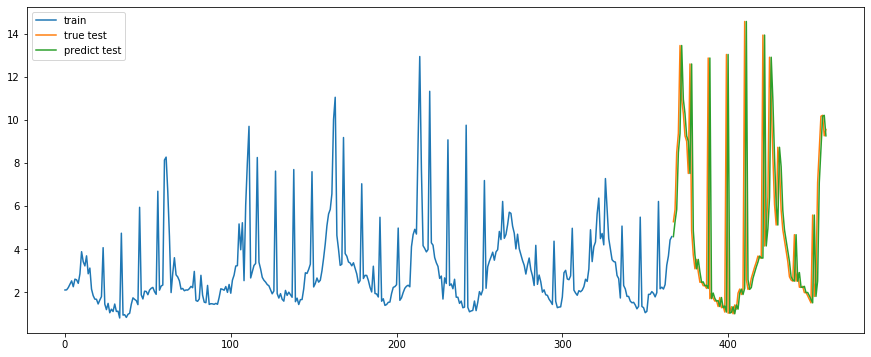

In [297]:
persistence('Texas')

### Auto Regression

In [351]:
def auto_regression(state, window, if_plot=True):
    # split dataset
    X = flu_df[state].values
    size = int(len(X)*0.8) # 80% training
    train, test = X[:size], X[size:]
    
    # train
    model = AutoReg(train, lags=window).fit()
    coef = model.params
    
    # predict
    history = train[len(train)-window:].tolist()
    preds = []
    for t in range(len(test)):
        N = len(history)
        lag = [history[i] for i in range(N - window, N)]
        yhat = coef[0]
        
        for w in range(window):
            yhat += coef[w+1] * lag[window-w-1]
            
        preds.append(yhat)
        history.append(test[t])
        
    print('Test MSE: ', mean_squared_error(test, preds))
    
    # plot
    if if_plot:
        plt.figure(figsize = [15, 6])
        plt.plot(test, label='true')
        plt.plot(predictions, label='predicted')
        plt.legend()
        plt.show()      

Test MSE:  6.126513047494596


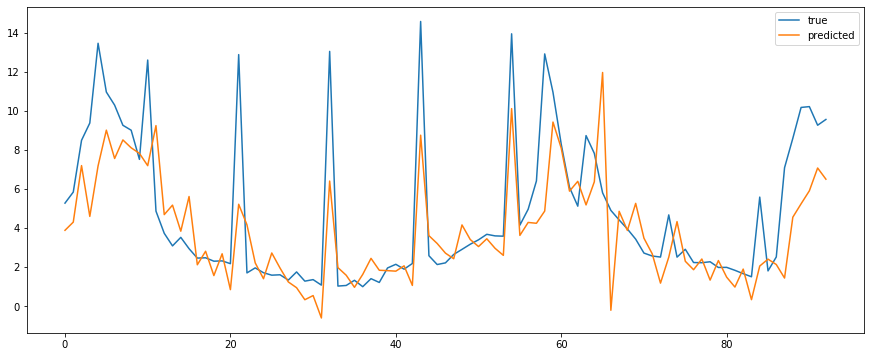

In [353]:
auto_regression('Texas', 15)